<a href="https://colab.research.google.com/github/Seligmann/carvana-image-masking-challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install git+https://github.com/tensorflow/examples.git
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import os
# import PIL
import numpy as np
import pathlib
import pandas as pd

import tensorflow_datasets as tfds
from PIL import Image
import cv2
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ny8oxvjw
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ny8oxvjw


In [47]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [48]:
import os

# # Upload the API token.
# def get_kaggle_credentials():
#   token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
#   token_file = os.path.join(token_dir, "kaggle.json")
#   if not os.path.isdir(token_dir):
#     os.mkdir(token_dir)
#   try:
#     with open(token_file,'r') as f:
#       pass
#   except IOError as no_file:
#     try:
#       from google.colab import files
#     except ImportError:
#       raise no_file
    
#     uploaded = files.upload()
    
#     if "kaggle.json" not in uploaded:
#       raise ValueError("You need an API key! see: "
#                        "https://github.com/Kaggle/kaggle-api#api-credentials")
#     with open(token_file, "wb") as f:
#       f.write(uploaded["kaggle.json"])
#     os.chmod(token_file, 600)

# get_kaggle_credentials()

In [49]:
# import kaggle

In [50]:
# Download competition data to /content
# !kaggle competitions download -c carvana-image-masking-challenge

In [51]:
metadata_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/metadata.csv'
train_masks_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/train_masks.csv'
train_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train'
train_masks_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks'
test_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/test'

In [52]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [53]:
metadata_df.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [54]:
train_masks_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [55]:
train_files = os.listdir(train_data)
train_mask_files = os.listdir(train_masks_data)
test_files = os.listdir(test_data)
print("Train files count:", len(train_files))
print("Train mask files count:", len(train_mask_files))
print("Test files count:", len(test_files))

Train files count: 5088
Train mask files count: 5088
Test files count: 100064


### Configuration

In [56]:
# Get unique ids for each of the photos in train and test datasets
train_ids = []
for n in train_files:
  train_ids.append(n.split("_")[0])

test_ids = []
for n in test_files:
  test_ids.append(n.split("_")[0])

train_mask_ids = []
for n in train_mask_files:
  train_mask_ids.append(n.split("_")[0])

In [57]:
# Using the training images and their masks, we want to create pairs of 
# NumPy matrices, in order to display each training image and it's mask as 
# images, as well as get their dimensions. We also need to trace an image to
# the path of it's training or testing ID.

# But, not all training images have an associated mask. Each training, test, and
# training mask file has an ID. If some training image has a training mask,
# they will share an id.

# Note: One ID is shared across it's testing, training, and/or mask image set.

# Example format of each file:
# * train_files[0]: 0cdf5b5d0ce1_01.jpg
# * train_mask_files[0]: cf65b1c5e147_09_mask.gif
# * test_files[0]: 3a2e36d7cd6a_01.jpg
# * train_ids[0]: cf65b1c5e147
# * train_mask_ids[0]: cf65b1c5e147
# * test_ids[0]: 0004d4463b50

def GetCarImageFiles(car_image_id, get_mask=False):
  if get_mask:
    if car_image_id in train_mask_ids:
      for n in train_mask_files:
        if car_image_id in n:
          return [train_masks_data + "/" + n]
    else:
      raise Exception("Input image does not have a mask ID")
  elif car_image_id in train_ids:
    for n in train_files:
      if car_image_id in n:
        return [train_data + "/" + n]
  elif car_image_id in test_ids:
    for n in test_files:
      if car_image_id in n:
        return [test_data + "/" + n]
  else:
    raise Exception("No test, train, or mask image with this ID found")

def GetImageMatrix(image_path):
  img = Image.open(image_path)
  return np.asarray(img, dtype=np.uint8)

['/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks/cf65b1c5e147_09_mask.gif']
['/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train/cf65b1c5e147_09.jpg']
Image shape: (1280, 1918, 3)
Image type: uint8
Mask shape: (1280, 1918)
Mask type: uint8


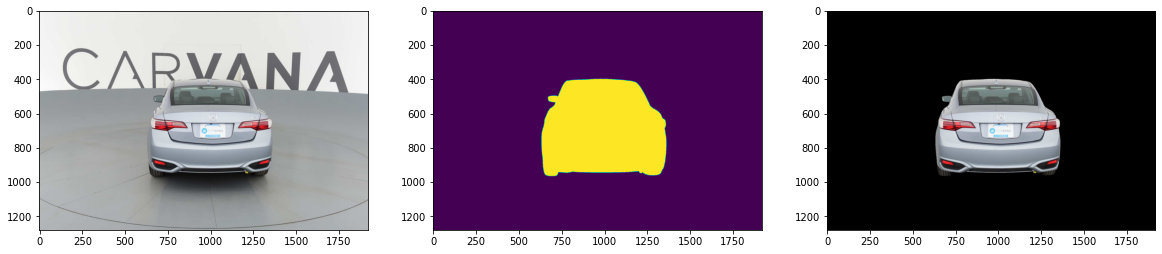

In [58]:
# Display single car with associated mask

# Get image and mask
path_to_mask = GetCarImageFiles(train_ids[0], get_mask=True)
print(path_to_mask)
mask = GetImageMatrix(path_to_mask[0])
path_to_image = GetCarImageFiles(train_ids[0])
print(path_to_image)
image = GetImageMatrix(path_to_image[0])
dest_and = cv2.bitwise_and(image, image, mask=mask)

print("Image shape:", image.shape)
print("Image type:", image.dtype)
print("Mask shape:", mask.shape)
print("Mask type:", mask.dtype)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(dest_and)

### Create dataframe using file paths

In [59]:
def CreateDataframe(img_path,mask_path):

# FIXME: understand *

    car_ids = []
    car_paths = []
    mask_ids=[]
    mask_paths=[]
    for p in (img_path,mask_path): # For all files in img_path and math_path
        for dirname, _, filenames in os.walk(p): # 
            for filename in filenames:
                path = os.path.join(dirname, filename)  
                if p==img_path:
                    car_paths.append(path)
                    car_id = filename.split(".")[0]
                    car_ids.append(car_id)
                    df=pd.DataFrame(data = {"id": car_ids, "img_path": car_paths}).set_index('id')
                else:
                    mask_paths.append(path)
                    mask_id = filename.split(".")[0]
                    mask_id = mask_id.split("_mask")[0]
                    mask_ids.append(mask_id)
                    df_mask=pd.DataFrame(data = {"id": mask_ids, "mask_path": mask_paths}).set_index('id')
                    
    df["mask_path"] = df_mask["mask_path"]

    return df

In [60]:
df = CreateDataframe(train_data,train_masks_data)
df.head()

,img_path,mask_path
id,,
cf65b1c5e147_09,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_10,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_11,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_12,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_13,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...


### Configuration

In [73]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
TRAIN_LENGTH = len(train_files)
IMAGE_SIZE = [256, 256]
EPOCHS = 40
SEED = 777
BATCH_SIZE = 16 
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

5088


NameError: ignored

### Loss function

In [62]:
# Credit:
# https://github.com/shruti-jadon/Semantic-Segmentation-Loss-Functions

# FIXME: understand the coding behind this loss function better


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

### Define the model

In [65]:
# Modified U-Net, consisting of an encoder and decoder.
# To learn robust features, and reduce the nu,ber of trainable parameters, a
# pretrained model can be used as the encoder

# FIXME: understand encoding-decoding process better

OUTPUT_CHANNELS = 1
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], 
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
# For every name within the base_model layer
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [66]:
# Decoder/upsampler 
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [67]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

In [68]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

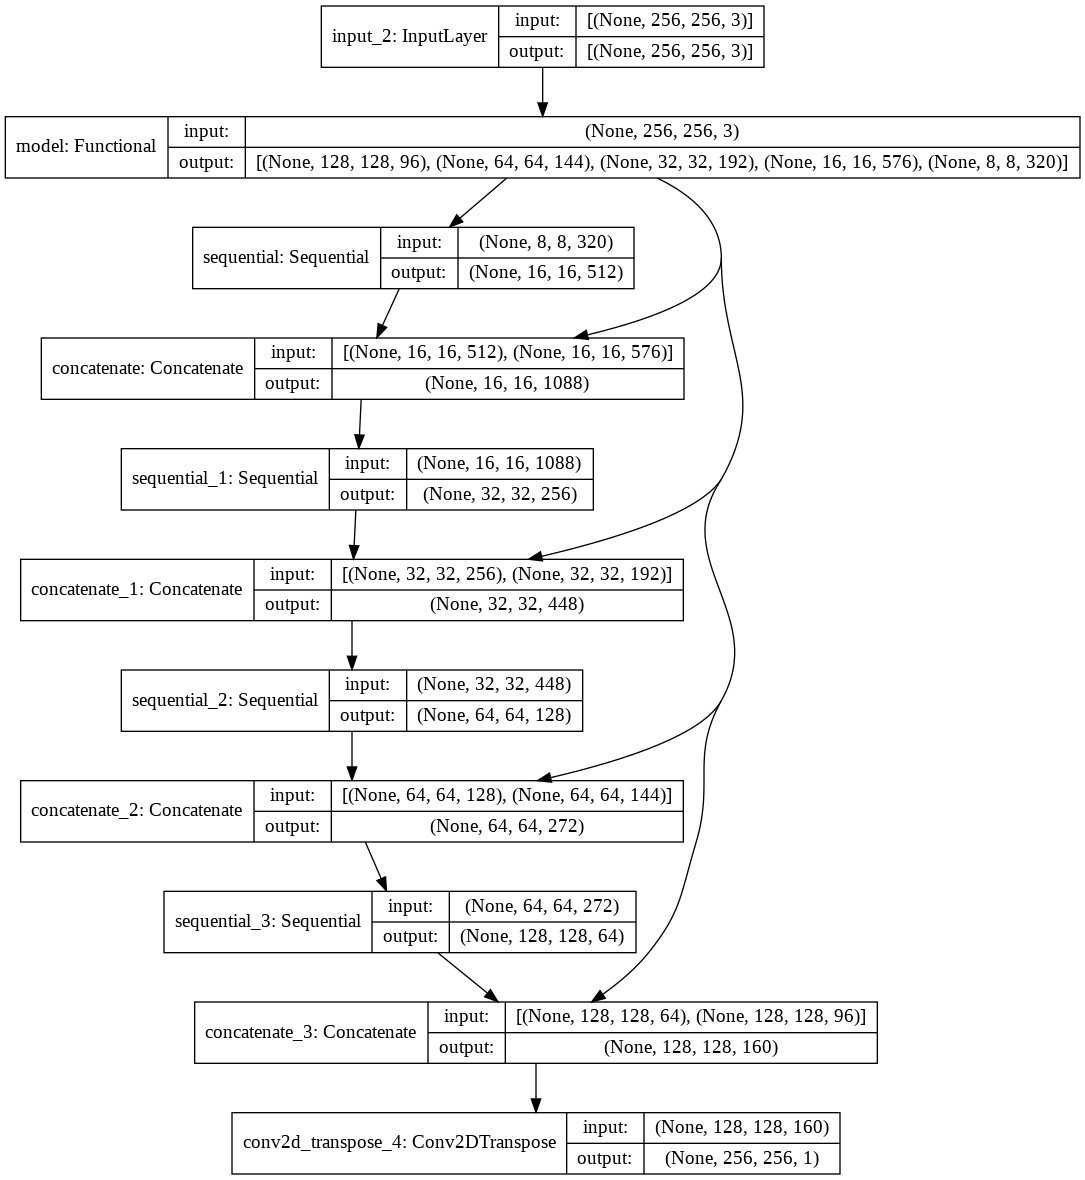

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [70]:
# What predictions are made before training

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [71]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [72]:
show_predictions()

NameError: ignored